In [1]:
import numpy as np
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [5]:
%pwd
%cd ..

c:\Users\jdu\Desktop\Projects\HandTracking


In [6]:
actions = ['giyeok', 'nieun', 'digeut', 'rieul']

data = np.concatenate([
    np.load('dataset/seq_giyeok_1635140505.npy'),
    np.load('dataset/seq_nieun_1635140505.npy'),
    np.load('dataset/seq_digeut_1635140505.npy'),
    np.load('dataset/seq_rieul_1635140505.npy')
], axis=0)

data.shape

(3461, 30, 100)

In [7]:
x_data = data[:, :, :-1]
labels = data[:, 0, -1]

print(x_data.shape)
print(labels.shape)

(3461, 30, 99)
(3461,)


In [8]:
from tensorflow.keras.utils import to_categorical

y_data = to_categorical(labels, num_classes=len(actions))
y_data.shape

(3461, 4)

In [9]:
from sklearn.model_selection import train_test_split

x_data = x_data.astype(np.float32)
y_data = y_data.astype(np.float32)

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.1, random_state=42)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(3114, 30, 99) (3114, 4)
(347, 30, 99) (347, 4)


In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential([
    LSTM(64, activation='relu', input_shape=x_train.shape[1:3]),
    Dense(32, activation='relu'),
    Dense(len(actions), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 64)                41984     
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 132       
Total params: 44,196
Trainable params: 44,196
Non-trainable params: 0
_________________________________________________________________


In [11]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=200,
    callbacks=[
        ModelCheckpoint('models/hand_sign_language.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto'),
        ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=50, verbose=1, mode='auto')
    ]
)

Epoch 1/200
98/98 [==============================] - 3s 15ms/step - loss: 19.1164 - acc: 0.5491 - val_loss: 2.3897 - val_acc: 0.7695

Epoch 00001: val_acc improved from -inf to 0.76945, saving model to models\hand_sign_language.h5
Epoch 2/200
98/98 [==============================] - 1s 13ms/step - loss: 0.8695 - acc: 0.8915 - val_loss: 0.1008 - val_acc: 0.9827

Epoch 00002: val_acc improved from 0.76945 to 0.98271, saving model to models\hand_sign_language.h5
Epoch 3/200
98/98 [==============================] - 1s 13ms/step - loss: 0.2151 - acc: 0.9637 - val_loss: 0.1943 - val_acc: 0.9769

Epoch 00003: val_acc did not improve from 0.98271
Epoch 4/200
98/98 [==============================] - 1s 13ms/step - loss: 0.1214 - acc: 0.9740 - val_loss: 0.0061 - val_acc: 0.9971

Epoch 00004: val_acc improved from 0.98271 to 0.99712, saving model to models\hand_sign_language.h5
Epoch 5/200
98/98 [==============================] - 1s 13ms/step - loss: 0.0408 - acc: 0.9936 - val_loss: 0.0188 - val_

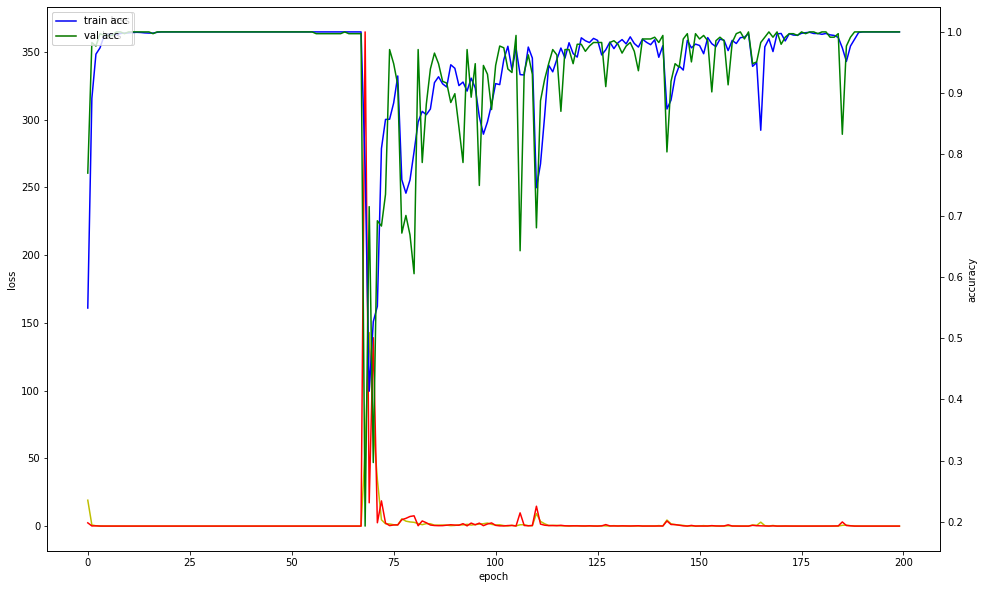

In [12]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(16, 10))
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

In [13]:
from sklearn.metrics import multilabel_confusion_matrix
from tensorflow.keras.models import load_model

model = load_model('models/hand_sign_language.h5')

y_pred = model.predict(x_val)

multilabel_confusion_matrix(np.argmax(y_val, axis=1), np.argmax(y_pred, axis=1))

array([[[250,   0],
        [  0,  97]],

       [[266,   0],
        [  0,  81]],

       [[264,   0],
        [  0,  83]],

       [[261,   0],
        [  0,  86]]], dtype=int64)

In [14]:
import tensorflow as tf
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('models/hand_sign_language.tflite', 'wb') as f:
    f.write(tflite_model)



INFO:tensorflow:Assets written to: C:\Users\jdu\AppData\Local\Temp\tmpotr0lgb9\assets
